Populating the interactive namespace from numpy and matplotlib


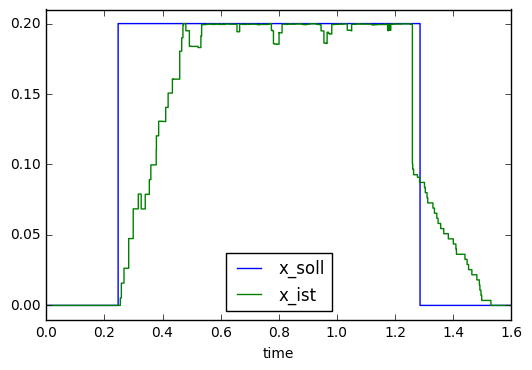

In [6]:
import pandas as pd
import numpy as np
from pandas import Series, DataFrame, Panel
%pylab inline
#plt.rcParams['figure.figsize'] = (15, 15)

### get soll ###
df_soll = pd.read_csv('~/catkin_ws/src/pitasc/applications/sysident/step_log/tmp/2017-07-26/2017-07-26_10-45-06_control_output.log',
                 header=0,
                 names=['time', 'x_soll'])
#print df_soll.head()

#remove trailing [
df_soll = df_soll.set_index('time')

### get ist ###
df_ist = pd.read_csv('~/catkin_ws/src/pitasc/applications/sysident/step_log/tmp/2017-07-26/2017-07-26_10-45-06_task_vel.log',
                 header=0,
                 names=['time', 'x_ist'])
df_ist = df_ist.set_index('time')

### make one df with ist and soll; indexed by time
# Concates both series to one and fills (unknown) data with last valid one
df_ist_soll = pd.concat([df_soll.x_soll, df_ist.x_ist], axis=1).fillna(method='pad')
# Fills first value with 0 (there is no valid before that one)
df_ist_soll = df_ist_soll.fillna(0)
df_ist_soll.plot(ylim=[-0.01, 0.21], xlim=[0, 1.6], style='-', drawstyle="steps")

In [7]:
# Load in the r magic
%load_ext rpy2.ipython

In [8]:
T = df_ist_soll.index.tolist()
yout = (5 * df_ist_soll['x_ist']).tolist()
xin = (5 * df_ist_soll['x_soll']).tolist()

# Don't know how to import more than one per line...
%R -i T
%R -i yout
%R -i xin

Discrete-time ARX mod: A(z)y[k] = B(z)u[k] + e[k] 

A(q^{-1}) = 1	- 0.9659 (+/- 0.0047) q^{-1}	
B(q^{-1}) = 0.009	 + 0.0225 (+/- 0.0139) q^{-1}	


 Fit Characteristics 
       MSE       FPE FitPer   AIC   AICc   nAIC   BIC
1 0.000421 0.0004242  95.21 -3883 -118.9 -7.765 -3869


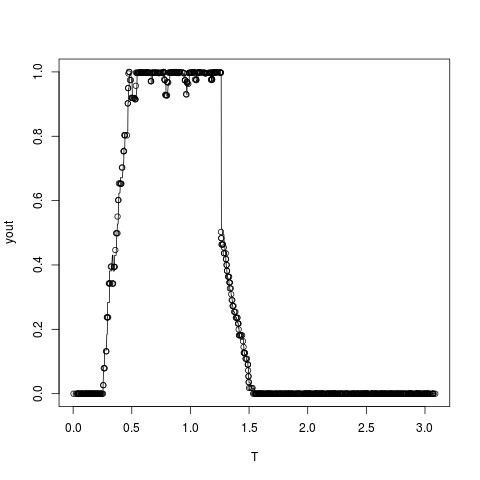

In [21]:
%%R -o sys
library(sysid)
require(ggplot2)

data_tf <- idframe(output = yout, input = xin)
sys = arx(data_tf, c(1,2,0))
#ls()
#names(sys)
#sys['fitted.values']
plot(T, yout)
lines(T, predict(sys, data_tf, nahead=2))
#print(sys)
names(sys)
print(sys)

In [91]:
#%R print(sys)


    0.2
----------
0.01 s + 1


          0.2
----------------------
0.01 s^2 + 0.166 s + 1

Populating the interactive namespace from numpy and matplotlib


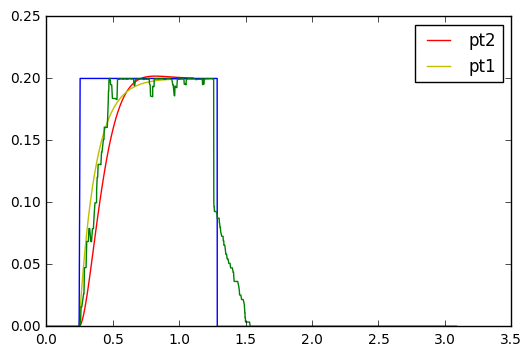

In [96]:
# Testsystem aufsetzen
import control as con

# pt1 System
k = 0.2
t = 1e-2

# Polynom
tf_pt1 = con.matlab.tf(k, [t, 1])
print tf_pt1


# pt2 System
K = 0.2
d = 0.83
T = .1
delay = 0.246

a0 = 1
a1 = (2 * d * T) #16
a2 = (T**2) #100
b0 = K

# Polynom
tf_pt2 = con.matlab.tf(K, [a2, a1, a0])
print tf_pt2

# Zustandsraum
ss_1a = con.matlab.tf2ss(tf_pt2)
#print ss_1a

# Füge Zeitversatz zu
d_num, d_den = con.pade(delay, 1)
tf_delay = con.tf(d_num, d_den)
ss_pt2_delay = con.series(tf_delay, tf_pt2)

tf_pt1_delay = con.tf(d_num, d_den)
ss_pt1_delay = con.series(tf_delay, tf_pt1)

#print con.matlab.tf2ss(ss_delay)

import matplotlib.pyplot as plt
%pylab inline
d_yout, d_T = con.matlab.step(ss_pt2_delay)
yout, T = con.matlab.step(tf_pt2) # step without delay

#plt.plot(d_T, d_yout, 'r-', label='poly_est')
plt.plot(np.add(d_T, delay), yout, 'r-', label='pt2') #delay in timeaxis!

d_yout, d_T = con.matlab.step(ss_pt1_delay)
yout, T = con.matlab.step(tf_pt1) # step without delay

#plt.plot(d_T, d_yout, 'r-', label='poly_est')
plt.plot(np.add(d_T, delay), yout, 'y-', label='pt1') #delay in timeaxis!


plt.legend()

plt.plot(df_ist_soll)
#df_ist_soll.plot(ylim=[-0.01, 0.21], xlim=[0.246, 1.2-0.246], style='-', drawstyle="steps")